In [1]:
#importing important libraries all in same place

import warnings
warnings.simplefilter('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from tensorflow import keras
from tensorflow.keras import layers
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler


sns.set_style('white')
sns.set_context('notebook')
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
url = 'Datasets\diabetes.csv'
data = pd.read_csv(url)
data.sample(3)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
42,7,106,92,18,0,22.7,0.235,48,0
272,3,122,78,0,0,23.0,0.254,40,0
451,2,134,70,0,0,28.9,0.542,23,1


In [3]:
data.shape

(768, 9)

<Axes: xlabel='Outcome'>

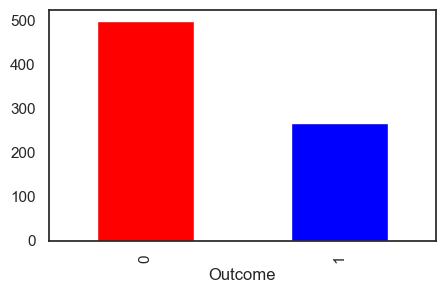

In [4]:
data.Outcome.value_counts().plot(kind = 'bar', figsize = (5,3), color = ['red', 'blue'])

In [5]:
data.Outcome.value_counts(normalize = True)

Outcome
0    0.651042
1    0.348958
Name: proportion, dtype: float64

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [7]:
data.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

The dataset is void of missing values. Its is clean

### Data Exploration 

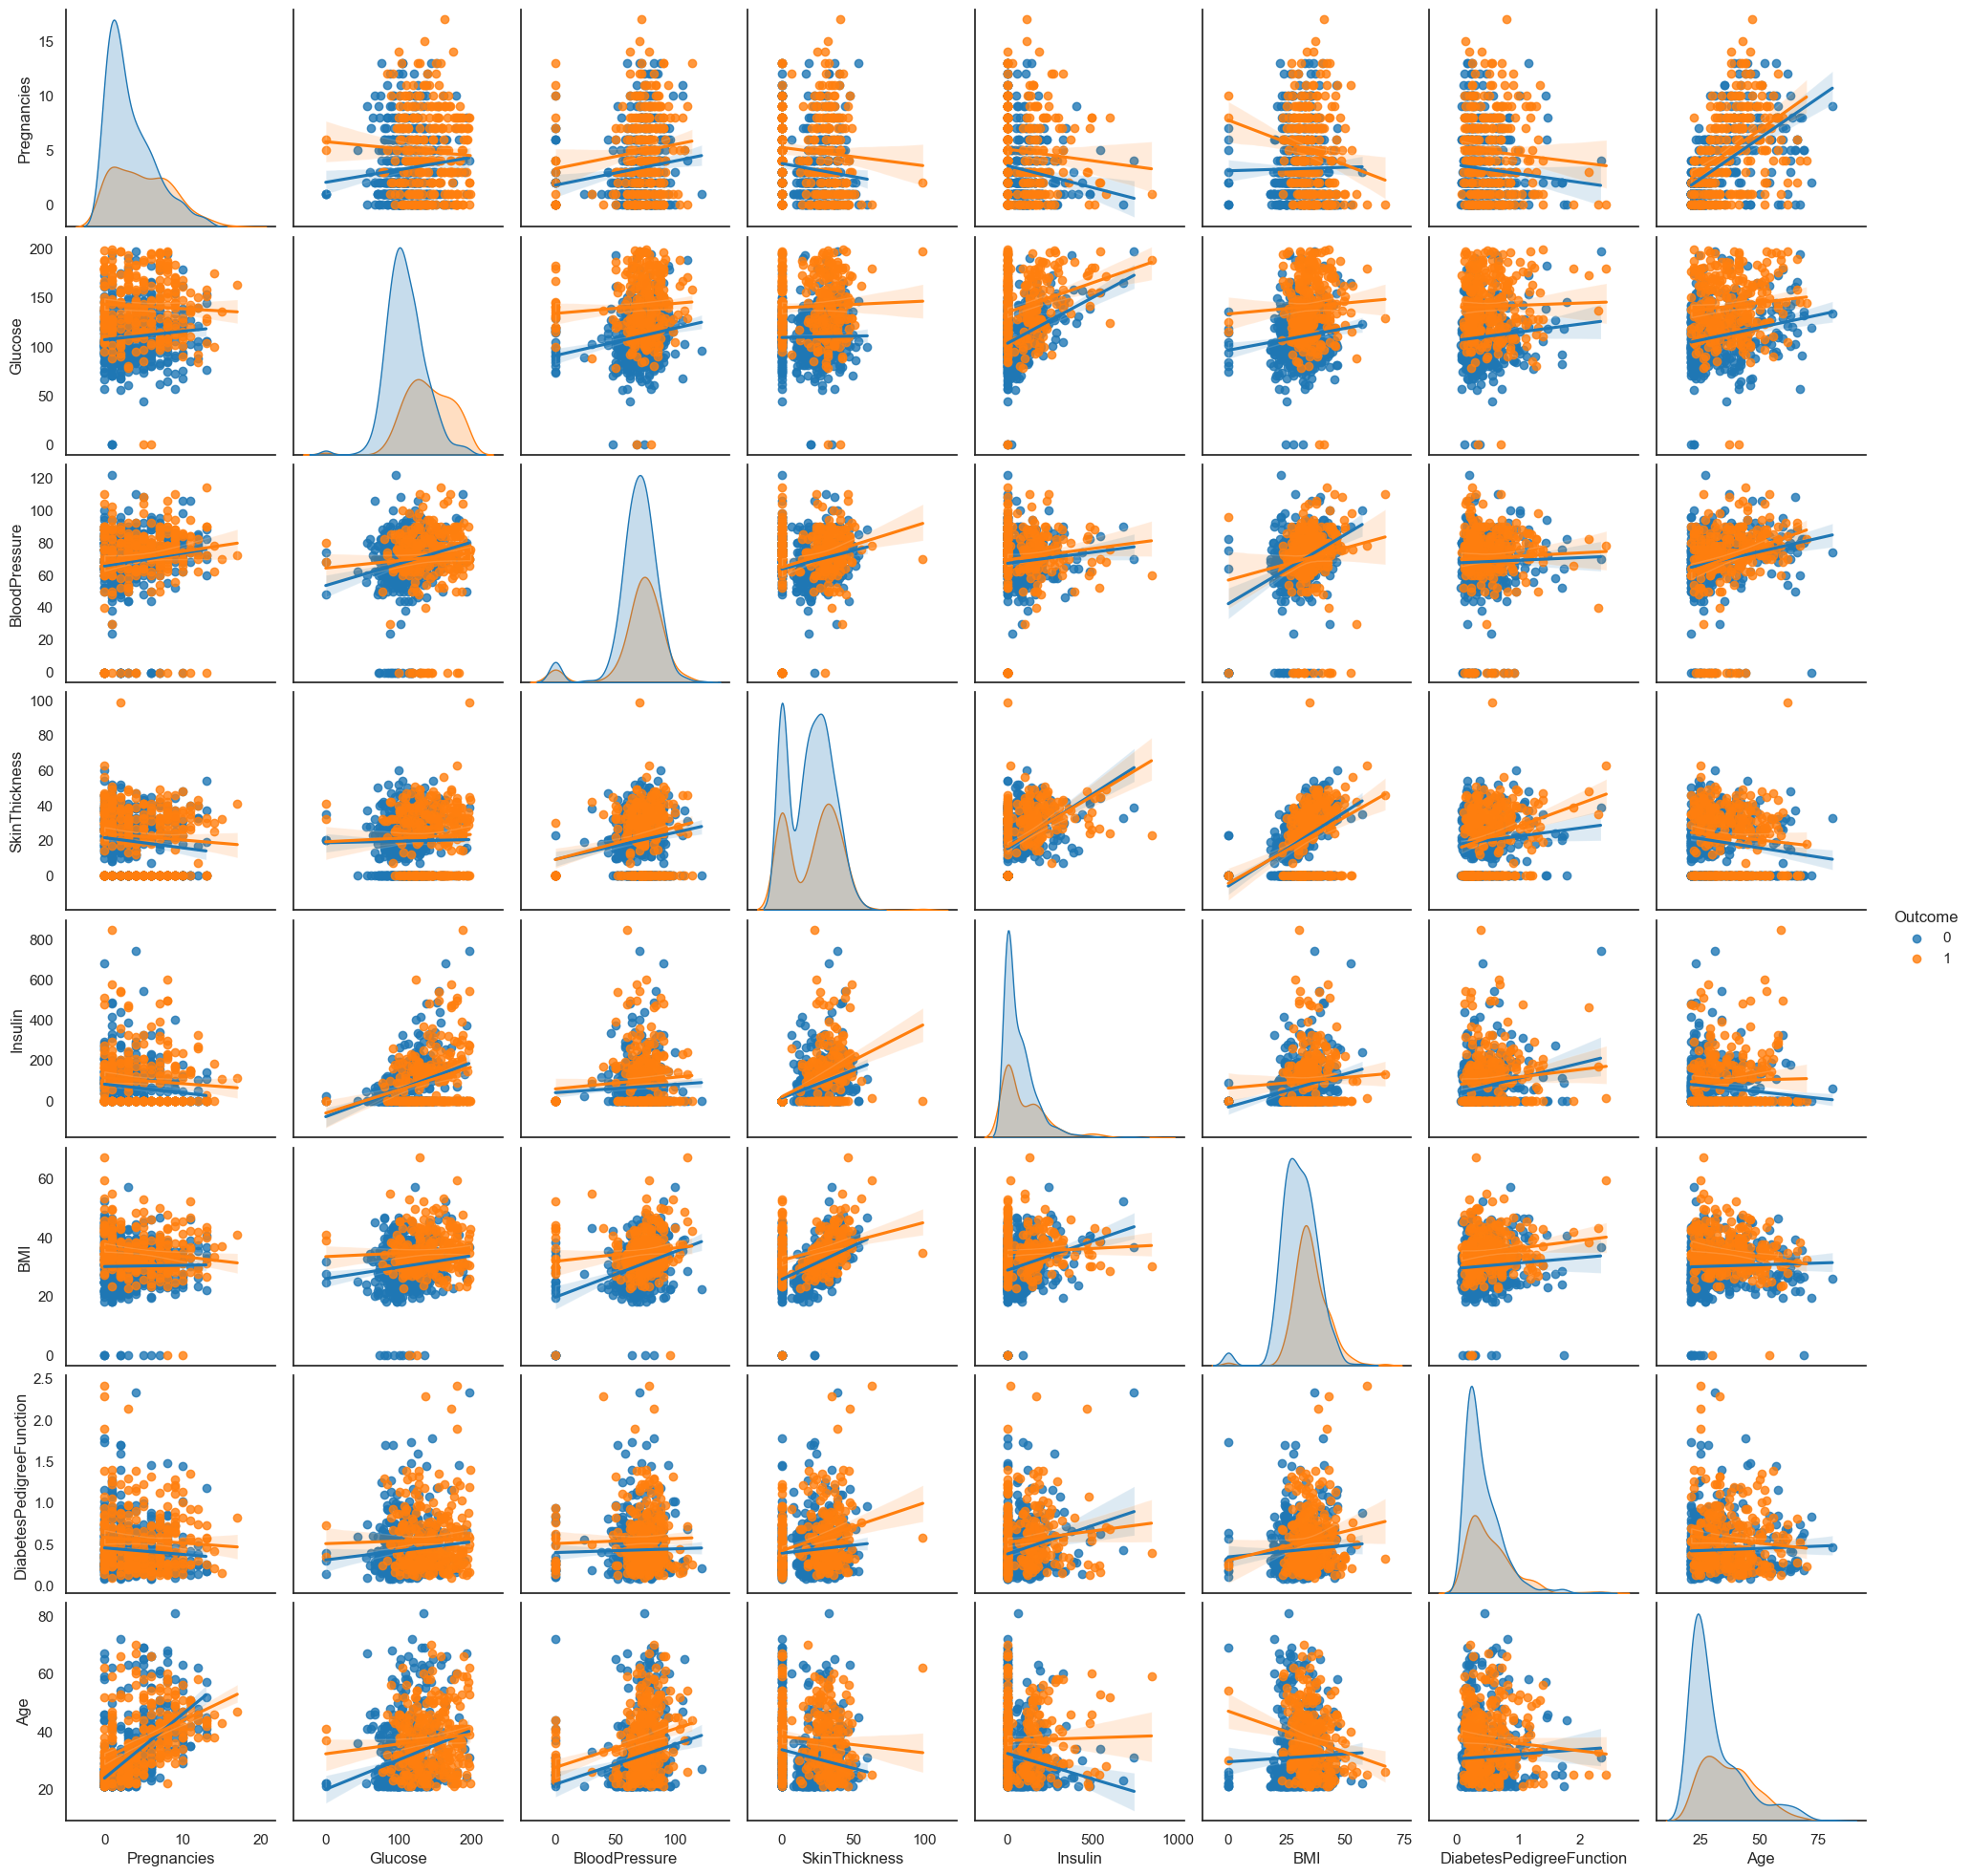

In [8]:
#Checking for relationship between variables and the target class

'''col = data.drop('Outcome', axis = 1)
col = col.columns.tolist()

plt.figure(figsize = [20,12])
for i in enumerate(col):
    plt.subplot(2,2,i[0]+1)
    sns.regplot(data = data, x = i[1], y = 'Outcome', line_kws = {'color': 'red'})
    
plt.show()'''

sns.pairplot(data, hue = 'Outcome', kind = 'reg')

#### We will create scatterplots for a few of our variables against the target variable

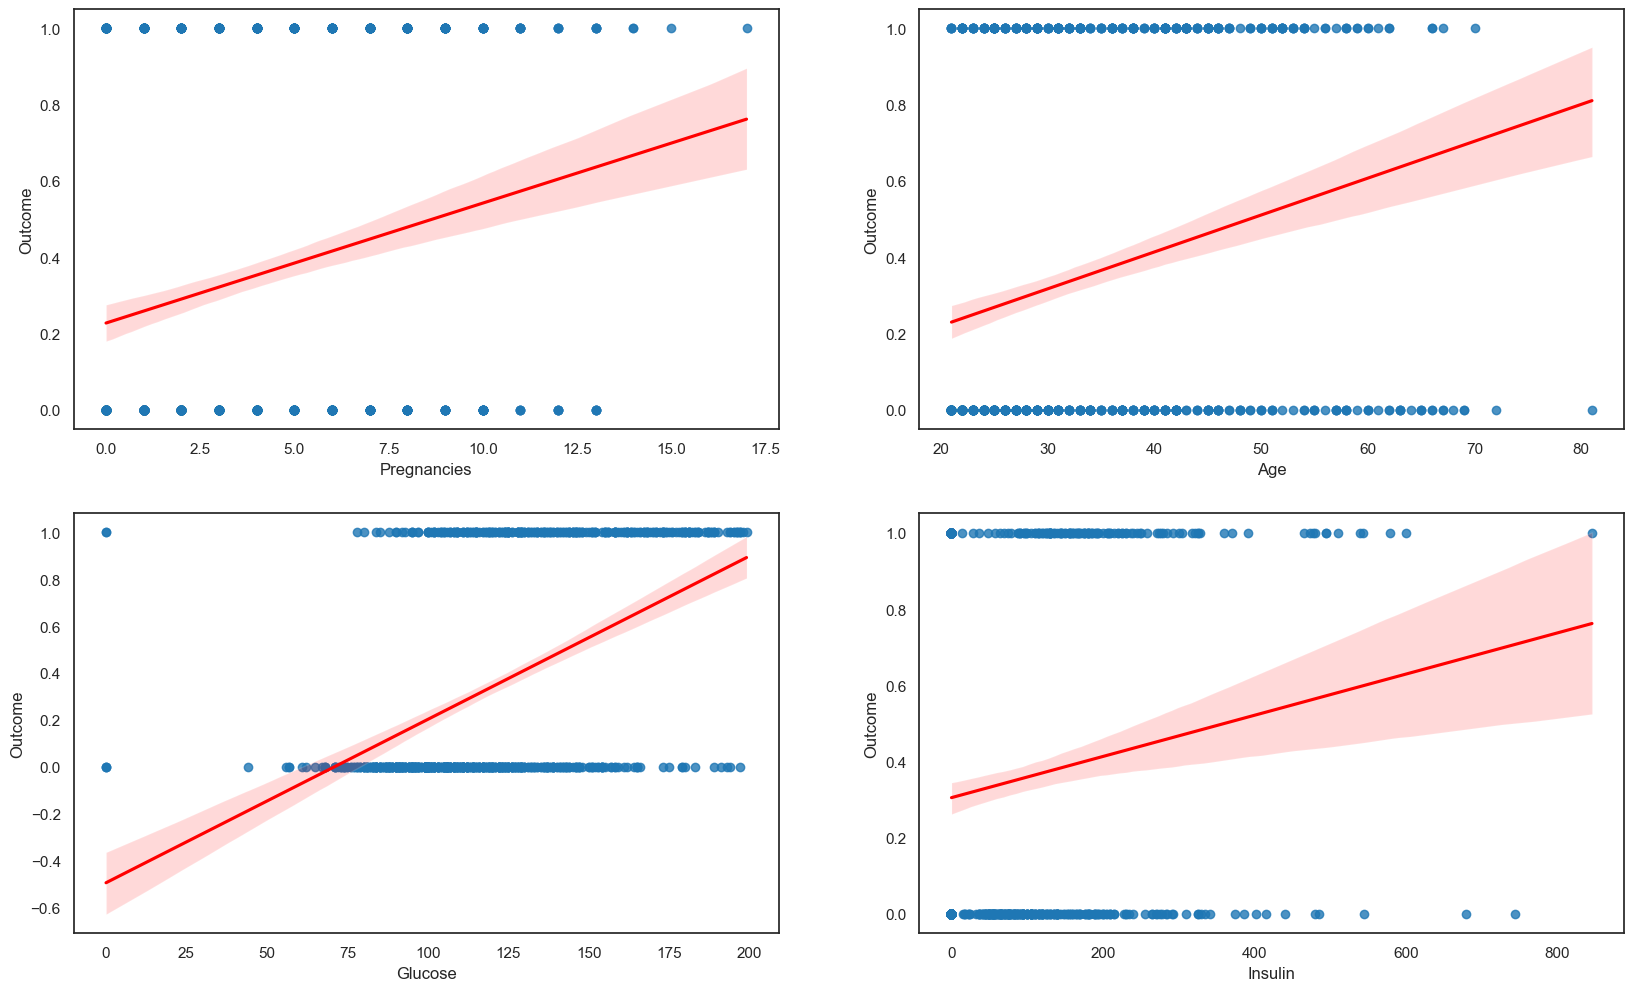

In [9]:
col = ['Pregnancies', 'Age', 'Glucose', 'Insulin']
plt.figure(figsize=[20,12])
for i in enumerate(col):
    plt.subplot(2,2,i[0]+1)
    sns.regplot(data=data,x=i[1],y='Outcome',line_kws={"color":'red'})
    
plt.show()

There are no reasonable relationship between these variables and the target class

### Doing a little more of bivariate analysis

#### We need to do this so as to take a closer look at the relationships between our variables and target class


<Axes: xlabel='Glucose', ylabel='Insulin'>

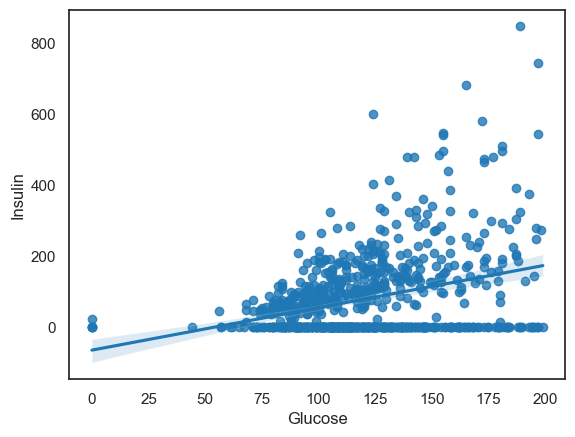

In [10]:
#sns.scatterplot(data = data['Glucose'], y = data['Outcome'], line_kws = {'color': 'red'})
sns.regplot(x = data['Glucose'], y = data['Insulin'])

We can see that there is a positive coleration between Glucose level and Insulin

<Axes: xlabel='Pregnancies', ylabel='Age'>

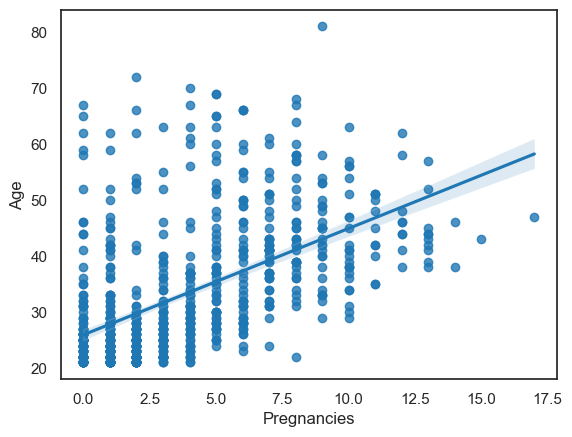

In [11]:
sns.regplot(x = data['Pregnancies'], y = data['Age'])

In [12]:
#train_features.sample(3)

#### Normalization

In [13]:
#We choose to use the minmaxscaler
scaler = MinMaxScaler()
data_features = data.drop('Outcome', axis = 1)
data_label = data.Outcome

data_features = scaler.fit_transform(data_features)

### Now let us split the data into train and test sets

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_recall_fscore_support, precision_score, recall_score
rs = 42
X_train, X_test, y_train, y_test = train_test_split(data_features, 
                                                    data_label, 
                                                    random_state = rs,
                                                   test_size = .2,
                                                   stratify = data_label)
print('Train X size is: {}'.format(X_train.shape))
print('Test X size is: {}'.format(X_test.shape))
print('Train y size is: {}'.format(y_train.shape))
print('Test y size is: {}'.format(y_test.shape))

Train X size is: (614, 8)
Test X size is: (154, 8)
Train y size is: (614,)
Test y size is: (154,)


### HELPER FUCNTION FOR PRINTING ACCURACY RESULT

In [15]:
def train_test_accuracy(model, X_train, X_test, y_train, y_test, name = ''):
    model.fit(X_train, y_train)
    
    train_acc =  round(model.score(X_train, y_train)*100, 2)
    
    y_pred = model.predict(X_test)
    acc = round(accuracy_score(y_pred, y_test)*100, 2)
    #print("The accuracy when using {} is: {}%". format(name,acc))
    
       
    cm = confusion_matrix(y_test, y_pred.round())
    sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues')
    plt.xlabel('predicted labels')
    plt.ylabel('Actual labels')
    plt.show()
    
    return print("The training accuracy when using {} is: {}% \n and the testing accuracy is {}% \n". format(name,train_acc,acc))

In [16]:
'''cm = confusion_matrix(y_test, y_pred.round())
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues')
plt.xlabel('predicted labels')
plt.ylabel('Actual labels')
plt.show()'''

"cm = confusion_matrix(y_test, y_pred.round())\nsns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues')\nplt.xlabel('predicted labels')\nplt.ylabel('Actual labels')\nplt.show()"

### Our first model to train will be the RANDOM FOREST
#### We will also use the 'accuracy' as the metrics

In [17]:
from sklearn.ensemble import RandomForestClassifier

model_RF = RandomForestClassifier(n_estimators = 100,
                                  random_state = rs,
                                 max_depth = 10,
                                 min_samples_split = 5,
                                 max_features = 'sqrt',
                                 bootstrap = False,
                                 class_weight = 'balanced',
                                 )
model_RF.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, class_weight='balanced', max_depth=10,
                       min_samples_split=5, random_state=42)

In [18]:
#lets check for feature importance using the Random Forest
feature_names = data.columns.tolist()
feature_names.remove('Outcome')
feature_importance = model_RF.feature_importances_
#print(feature_names )
feature_importance_df = pd.DataFrame({'Feature': feature_names,
                                    'Importances': feature_importance})

In [19]:
# Sort features by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by = 'Importances',
                                                          ascending = False)
feature_importance_df

,Feature,Importances
1,Glucose,0.305507
5,BMI,0.180866
7,Age,0.130413
6,DiabetesPedigreeFunction,0.111660
0,Pregnancies,0.073425
2,BloodPressure,0.071781
4,Insulin,0.068130
3,SkinThickness,0.058218


We can see that glucose of one of the most contributing factor to diabetes.

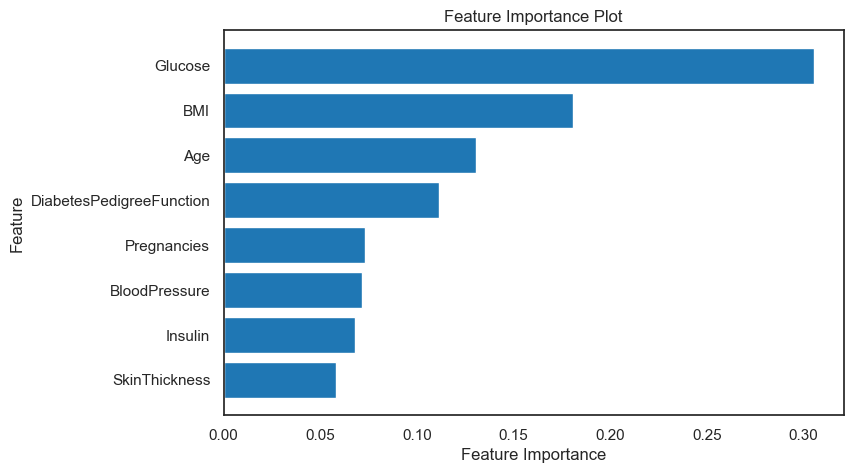

In [20]:
plt.figure(figsize = (8,5))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importances'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance Plot')
plt.gca().invert_yaxis() 
plt.show()

### Our second model to train will be the LOGISTIC REGRESSION
#### We will also use the 'accuracy' as the metrics

In [23]:
from sklearn.linear_model import LogisticRegression

model_LR = LogisticRegression( random_state = rs, max_iter = 500)
model_LR.fit(X_train, y_train)

LogisticRegression(max_iter=500, random_state=42)

In [24]:
feature_coefficients = model_LR.coef_[0]


In [49]:
feature_coefficients = model_LR.coef_[0]

# Assuming feature_names is a list of feature names
for feature, coefficient in zip(feature_names, feature_coefficients):
    print(f"Feature: {feature}, Coefficient: {coefficient}")

Feature: Pregnancies, Coefficient: 1.3535945225782093
Feature: Glucose, Coefficient: 4.682090904278121
Feature: BloodPressure, Coefficient: -0.4215104229479624
Feature: SkinThickness, Coefficient: 0.3899084988338017
Feature: Insulin, Coefficient: 0.11653128758870716
Feature: BMI, Coefficient: 3.080489788346175
Feature: DiabetesPedigreeFunction, Coefficient: 1.24174956584585
Feature: Age, Coefficient: 1.0264239605621306


In [50]:
feature_importance_df = pd.DataFrame({'Features': feature_names,
                                     'Importances': feature_coefficients})

In [52]:
# Sort features by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by = 'Importances',
                                                          ascending = False)
feature_importance_df

,Features,Importances
1,Glucose,4.682091
5,BMI,3.080490
0,Pregnancies,1.353595
6,DiabetesPedigreeFunction,1.241750
7,Age,1.026424
3,SkinThickness,0.389908
4,Insulin,0.116531
2,BloodPressure,-0.421510


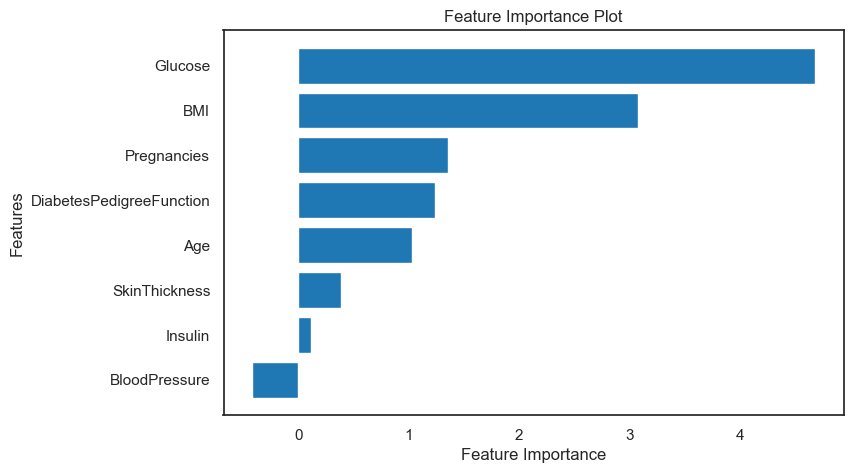

In [54]:
plt.figure(figsize = (8,5))
plt.barh(feature_importance_df['Features'], feature_importance_df['Importances'])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance Plot')
plt.gca().invert_yaxis() 
plt.show()

### Our third model to train will be the MULTILAYER PERCEPTRON (MLP)

In [26]:
from sklearn.neural_network import MLPClassifier

model_MLP = MLPClassifier(random_state = rs,
                         hidden_layer_sizes = (32,8),
                         solver = 'sgd',
                         momentum = 0,
                         early_stopping = True,
                         max_iter = 500)#two hidden layers each with 32 and 8 neurons

In [27]:
#OPTIMIZING THE MLP WITH Nesterov’s momentum
model_OMLP = MLPClassifier(random_state = 123,
                             hidden_layer_sizes = (32, 8),
                             early_stopping = False,
                             solver = 'adam',
                             nesterovs_momentum = True,
                             momentum = 0.90,
                             max_iter = 500)

In [28]:
#Trying randomize search for the Nesterov's momentum MLP
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

solver = ['sgd', 'adam']
max_iter = [100, 200, 500, 700]
momentum = [0.30, 0.50, 0.80, 0.90, 1.00]
params = dict(solver = solver, max_iter = max_iter, momentum = momentum)

search = RandomizedSearchCV(estimator  = model_OMLP, param_distributions=params, cv=3)

search_result = search.fit(X_train, y_train)





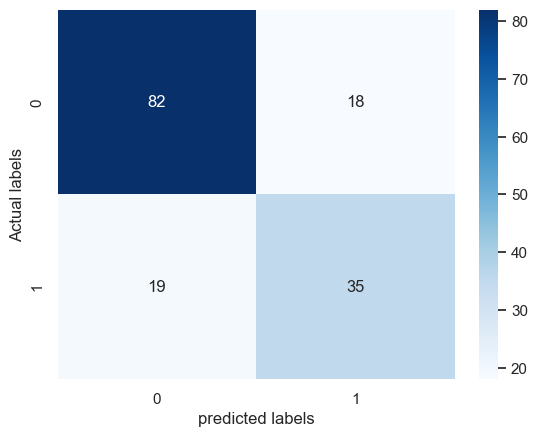

The training accuracy when using RANDOM FOREST is: 99.84% 
 and the testing accuracy is 75.97% 



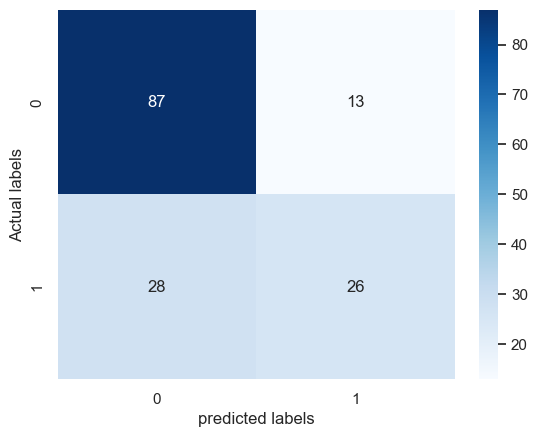

The training accuracy when using LOSGISTIC REGRESSION is: 78.5% 
 and the testing accuracy is 73.38% 



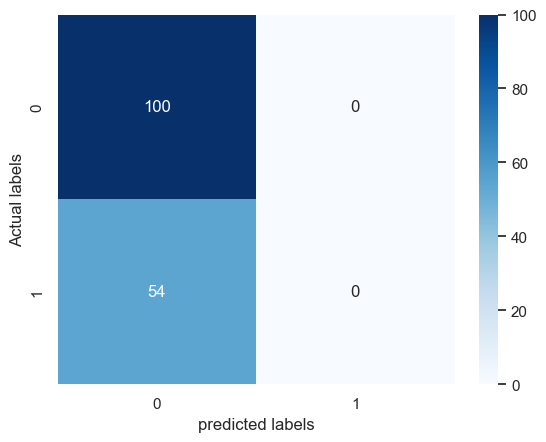

The training accuracy when using MULTILAYER PERCEPTRON is: 65.31% 
 and the testing accuracy is 64.94% 



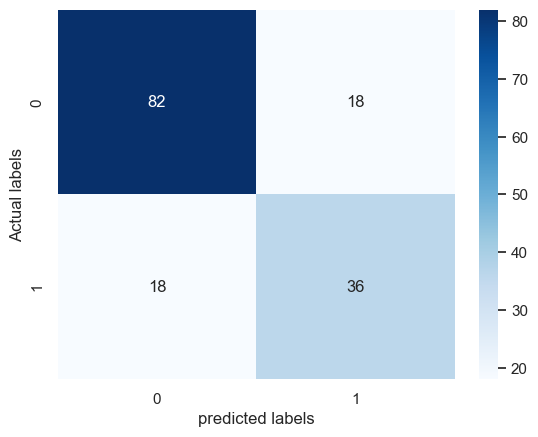

The training accuracy when using OPTIMIZED MULTILAYER PERCEPTRON is: 79.48% 
 and the testing accuracy is 76.62% 

Best mean cross-validated score for Nesterov's momentum MLP: 77.0% 
 using {'solver': 'adam', 'momentum': 0.3, 'max_iter': 500}


In [29]:
train_test_accuracy(model_RF, X_train, X_test, y_train, y_test, name = 'RANDOM FOREST')
train_test_accuracy(model_LR, X_train, X_test, y_train, y_test, name = 'LOSGISTIC REGRESSION')
train_test_accuracy(model_MLP, X_train, X_test, y_train, y_test, name = 'MULTILAYER PERCEPTRON')
train_test_accuracy(model_OMLP, X_train, X_test, y_train, y_test, name = 'OPTIMIZED MULTILAYER PERCEPTRON')
print("Best mean cross-validated score for Nesterov's momentum MLP: {}% \n using {}".format(round(search_result.best_score_,3)*100, search_result.best_params_))

### Using the Feed Forward NN

In [30]:
X_train.shape

(614, 8)

Text(0, 0.5, 'feature 2')

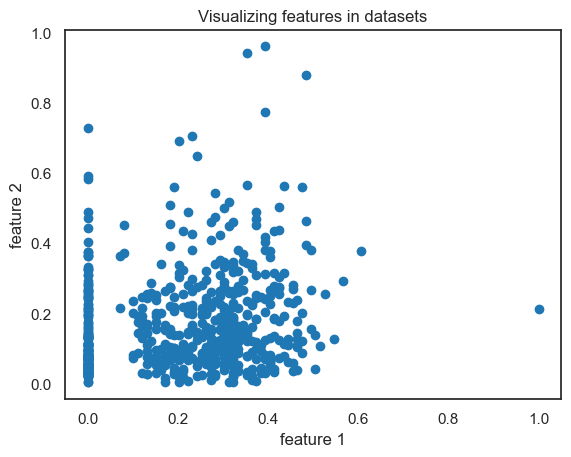

In [31]:
plt.scatter(X_train[:,3], X_train[:,6])
plt.title('Visualizing features in datasets')
plt.xlabel('feature 1')
plt.ylabel('feature 2')

The two features we sampled are not linearly separable, thus CNN sdould be able to unravel this non linear relatioship

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [33]:
feature_vector_shape = (X_train.shape[1],)
input_shape = (feature_vector_shape)

In [34]:
model = Sequential()
model.add(Dense(12, input_shape = input_shape,
               activation = 'relu',
               kernel_initializer = 'he_uniform', kernel_regularizer=keras.regularizers.l1(l=0.01)))
model.add(Dense(8, activation = 'relu',
               kernel_initializer = 'he_uniform', kernel_regularizer=keras.regularizers.l1(l=0.01)))
model.add(Dense(1, activation = 'sigmoid'))

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12)                108       
                                                                 
 dense_1 (Dense)             (None, 8)                 104       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 221 (884.00 Byte)
Trainable params: 221 (884.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [36]:
from tensorflow.keras.losses import BinaryCrossentropy
loss_function_used  = BinaryCrossentropy(from_logits = True)

In [37]:
model.compile(loss = loss_function_used,
             optimizer = tf.keras.optimizers.Adam(learning_rate= 0.01 ),
              metrics = ['accuracy'])

In [38]:
model.fit(X_train, y_train,
         verbose = 1,
         epochs = 30,
         batch_size = 5)

Epoch 1/30
123/123 [==============================] - 1s 2ms/step - loss: 0.8974 - accuracy: 0.6450
Epoch 2/30
123/123 [==============================] - 0s 2ms/step - loss: 0.6746 - accuracy: 0.6515
Epoch 3/30
123/123 [==============================] - 0s 2ms/step - loss: 0.6594 - accuracy: 0.6515
Epoch 4/30
123/123 [==============================] - 0s 2ms/step - loss: 0.6536 - accuracy: 0.6515
Epoch 5/30
123/123 [==============================] - 0s 2ms/step - loss: 0.6363 - accuracy: 0.6515
Epoch 6/30
123/123 [==============================] - 0s 2ms/step - loss: 0.6231 - accuracy: 0.6515
Epoch 7/30
123/123 [==============================] - 0s 2ms/step - loss: 0.5976 - accuracy: 0.6954
Epoch 8/30
123/123 [==============================] - 0s 2ms/step - loss: 0.5873 - accuracy: 0.7459
Epoch 9/30
123/123 [==============================] - 0s 2ms/step - loss: 0.5684 - accuracy: 0.7410
Epoch 10/30
123/123 [==============================] - 0s 2ms/step - loss: 0.5674 - accuracy: 0.7557

In [39]:
test_score = model.evaluate(X_test, y_test, verbose = 1)
print(f'The loss of the test set is: {round(test_score[0], 3)},\n and the accuracy is: {round(test_score[1]*100,2)}%')

5/5 [==============================] - 0s 5ms/step - loss: 0.5455 - accuracy: 0.7078
The loss of the test set is: 0.545,
 and the accuracy is: 70.78%


### CNN MODEL
although CNN is used mostly for image data, we will try using it here

In [40]:
first_shape = (X_train.shape[1])
input_shape = (first_shape,)
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1, 1)

In [41]:
#we reshape our dataset for CNN input
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1, 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1, 1)

In [59]:
# Build the CNN model
model2 = keras.Sequential([
    layers.Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    layers.MaxPooling1D(pool_size=2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
model2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 6, 32)             128       
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 3, 32)             0         
 g1D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 96)                0         
                                                                 
 dense_13 (Dense)            (None, 64)                6208      
                                                                 
 dense_14 (Dense)            (None, 1)                 65        
                                                                 
Total params: 6401 (25.00 KB)
Trainable params: 6401 (25.00 KB)
Non-trainable params: 0 (0.00 Byte)
____________________

In [43]:
# Compile the model
model2.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.002),
               loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [44]:
# Train the model
model2.fit(X_train, y_train, epochs = 30, batch_size = 5)

Epoch 1/30
123/123 [==============================] - 1s 2ms/step - loss: 0.6654 - accuracy: 0.6482
Epoch 2/30
123/123 [==============================] - 0s 2ms/step - loss: 0.6408 - accuracy: 0.6498
Epoch 3/30
123/123 [==============================] - 0s 2ms/step - loss: 0.5802 - accuracy: 0.7085
Epoch 4/30
123/123 [==============================] - 0s 2ms/step - loss: 0.5219 - accuracy: 0.7557
Epoch 5/30
123/123 [==============================] - 0s 2ms/step - loss: 0.5024 - accuracy: 0.7687
Epoch 6/30
123/123 [==============================] - 0s 2ms/step - loss: 0.4810 - accuracy: 0.7769
Epoch 7/30
123/123 [==============================] - 0s 2ms/step - loss: 0.4887 - accuracy: 0.7769
Epoch 8/30
123/123 [==============================] - 0s 2ms/step - loss: 0.4718 - accuracy: 0.7818
Epoch 9/30
123/123 [==============================] - 0s 2ms/step - loss: 0.4647 - accuracy: 0.7834
Epoch 10/30
123/123 [==============================] - 0s 2ms/step - loss: 0.4605 - accuracy: 0.7801

In [45]:
# Evaluate the model on the test set
test_score = model2.evaluate(X_test, y_test)
print(f'the loss of test data is:{round(test_score[0],2)},\n The accuracy is: {round(test_score[1]*100,2)}')

5/5 [==============================] - 0s 3ms/step - loss: 0.5022 - accuracy: 0.7532
the loss of test data is:0.5,
 The accuracy is: 75.32


In [46]:
predictions = model2.predict(X_test)

5/5 [==============================] - 0s 4ms/step


### Visualizing using the confusion matrix for our CNN model

In [47]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

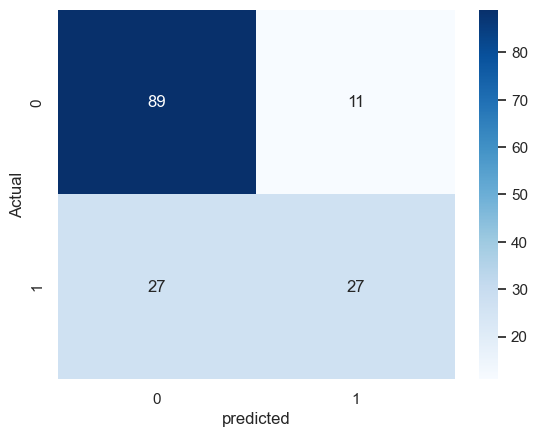

In [48]:
cm = confusion_matrix(y_test, predictions.round())
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues')
plt.xlabel('predicted')
plt.ylabel('Actual')
plt.show()

This shows that out CNN model did fairly well in correctly predicting.

## End of Project